<H2><b><center>Implementation of Quantum Fourier Transform</b></center></h3>
<h4><center>Seong Axel Cho</center></h4>

<center>Computer Science Department, Vanderbilt University</center>
    
<center>2201 West End Ave. Nashville TN 37235, United States</center>

<center>seong.g.cho@vanderbilt.edu</center

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, transpile
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
from math import gcd

pi = np.pi

<h4><b>Three Qubit QFT</b></h4>

This is implementation of 3 qubit Quantum Fourier Transform

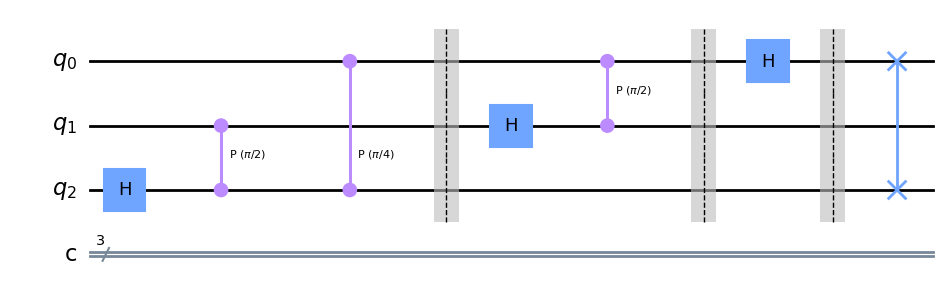

In [2]:
# build a Quantum Fourier Transformer for 3 qubits

# initialize the circuit with 3 qubits
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
q3 = QuantumCircuit(q, c)

# the bottom qubit at qubit[2], hadamard, then controlled phase rotation on 0, 1
q3.h(2)
q3.cp(pi/2, 2, 1)
q3.cp(pi/4, 2, 0)
q3.barrier()

# qubit[1], hadamard, then controlled phase rotation on 0
q3.h(1)
q3.cp(pi/2, 1, 0)
q3.barrier()

# qubit[0], hadamard only, as it does not have any more qubits to control
q3.h(0)
q3.barrier()

# swap top and bottom till we reach the center
q3.swap(0,2)

# draw the circuit that worked so far
q3.draw()

<h4><b>Four Qubit QFT</b></h4>

The following shows an actual 4 qubit Quantum Fourier Transform 

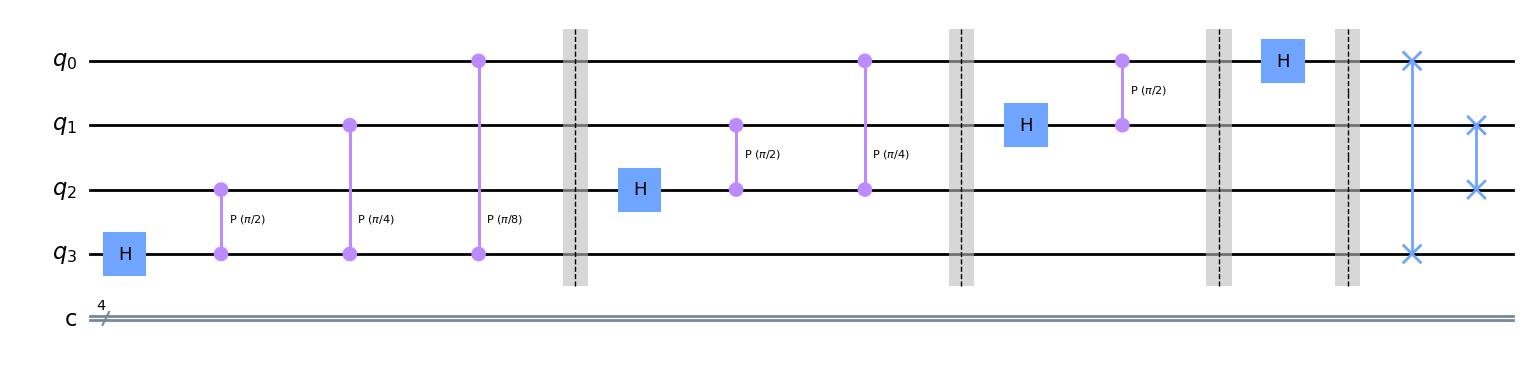

In [3]:
# build a Quantum Fourier Transformer for 4 qubits

# initialize the circuit with 4 qubits
q = QuantumRegister(4, 'q')
c = ClassicalRegister(4, 'c')
q4 = QuantumCircuit(q, c)

# start from the bottom (qubit[3]), apply hadamard gate, then run controlled phase rotation with other 3 qubits above (0, 1, 2). 
q4.h(3)
q4.cp(pi/2, 3, 2)
q4.cp(pi/4, 3, 1)
q4.cp(pi/8, 3, 0)
q4.barrier()

# qubit[2], hadarmard, then controlled phase rotation on 0, 1
q4.h(2)
q4.cp(pi/2, 2, 1)
q4.cp(pi/4, 2, 0)
q4.barrier()

# qubit[1], hadamard, then controlled phase rotation on 0
q4.h(1)
q4.cp(pi/2, 1, 0)
q4.barrier()

# qubit[0], hadamard only, as it does not have any more qubits to control
q4.h(0)
q4.barrier()

# swap top and bottom till we reach the center
q4.swap(0,3)
q4.swap(1,2)

# draw the circuit that worked so far
q4.draw()

<h4><b>QFT building as a function</b></h4> 

As the QFT building involves only 3 steps, and the steps are repetitive, it can be written as a function. 

The inverse QFT can be written into another function, which is just the same logic with reversed order. 

In [4]:
    # build the transformer    
    def build_qft(numbers): 
        q = QuantumRegister(numbers, 'q')
        c = ClassicalRegister(numbers, 'c')
        circuit = QuantumCircuit(q, c)
        
        k = numbers
        while (k > 0):
            k = k -1
            
            # hadamard gate
            circuit.h(k)
            rotation = pi            
            j = k
            
            while (j > 0):
                j = j -1
                rotation = rotation/2
                
                # controlled phase gate
                circuit.cp(rotation, k, j)                  
        
            circuit.barrier()
       
        top = 0
        bottom = numbers -1
        
        while (top < bottom):            
            # swap the qubits
            circuit.swap(top, bottom)
            top = top + 1
            bottom = bottom -1
            
            
        return circuit 
    
    # build inverse version
    def build_inverse(numbers):   
        
        q = QuantumRegister(numbers, 'q')
        c = ClassicalRegister(numbers, 'c')
        circuit = QuantumCircuit(q, c)
        
        # swap first
        high = numbers -1
        low = 0
        
        while (high > low):
            circuit.swap(high, low)
            high = high -1
            low = low + 1 
            
        circuit.barrier()    
                
        k = 0
        
        while (k < numbers):
            j = 0
            divide = 2 ** k                       
            
            while (j < k):               
                rotation = pi/divide
                
                # controlled phase rotation
                circuit.cp(rotation, k, j)
                
                j = j + 1
                divide = divide/2                                           
              
            # hadamard gate
            circuit.h(k)
            
            k = k + 1      
            
            circuit.barrier()
            
        return circuit   

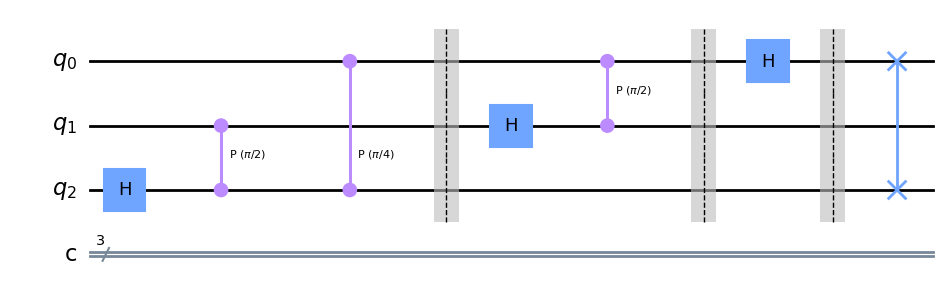

In [5]:
q3 = build_qft(3)
q3.draw()

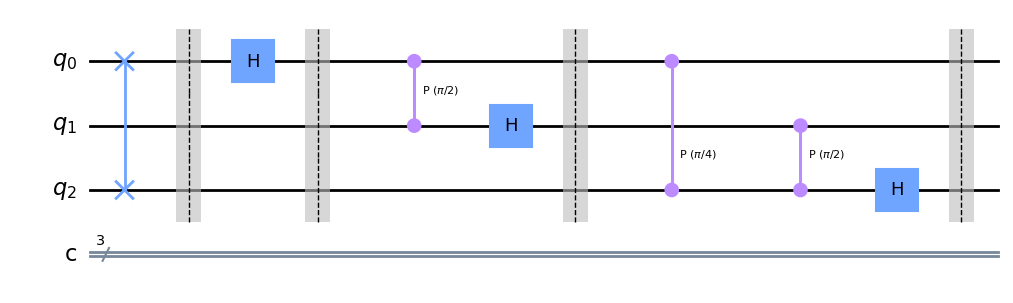

In [6]:
qi3 = build_inverse(3)
qi3.draw()

<h4><b>QFT operator in Qiksit</b></h4>

While building this QFT circuit can be defined as a python operator as shown above, there exists a pre-built QFT package in Qiskit. [6] There is no difference between the outputs from qiskit's method or from the methods defined above. The only difference is that we should decompose the circuit first before drawing, so that we can see the internal structures of the QFT circuits. 

References

[6] https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html

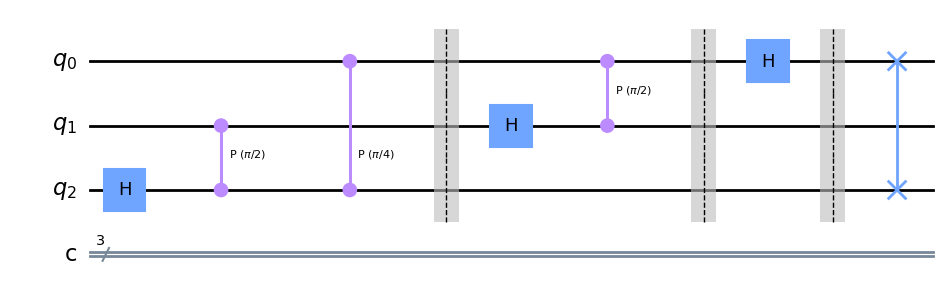

In [7]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(q, c)

circuit &= QFT(3, 0, True, False, True)

circuit.decompose().draw()

<h4><b>QFT class</b></h4>

Putting all these together, both manaul building methods and Qiskit's QFT function, this can be written as a single class object where we can build QFT like a factory. 

In [8]:
class FourierClass:
    # the constructor takes one required param (numbers) and one optional param (reverse)
    def __init__(self, numbers, reverse=False):
        # pass the params to the class properties
        self.numbers = numbers
        self.reverse = reverse
        
        # initialize the circuit 
        q = QuantumRegister(numbers, 'q')
        c = ClassicalRegister(numbers, 'c')
        self.circuit = QuantumCircuit(q, c)
        
    # output the circuit at this moment    
    def get_circuit(self):
        return self.circuit
        
    # manually build the transformer    
    def build_manually(self):        
        k = self.numbers
        while (k > 0):
            k = k -1
            
            # hadamard gate
            self.circuit.h(k)
            rotation = pi            
            j = k
            
            while (j > 0):
                j = j -1
                rotation = rotation/2
                
                # controlled phase gate
                self.circuit.cp(rotation, k, j)                  
        
            self.circuit.barrier()
       
        top = 0
        bottom = self.numbers -1
        
        while (top < bottom):            
            # swap the qubits
            self.circuit.swap(top, bottom)
            top = top + 1
            bottom = bottom -1
            
            
        return self.circuit 
    
    # manually build inverse version
    def build_inverse_manually(self):        
        
        # swap first
        high = self.numbers -1
        low = 0
        
        while (high > low):
            self.circuit.swap(high, low)
            high = high -1
            low = low + 1 
            
        self.circuit.barrier()    
                
        k = 0
        
        while (k < self.numbers):
            j = 0
            divide = 2 ** k                       
            
            while (j < k):               
                rotation = pi/divide
                
                # controlled phase rotation
                self.circuit.cp(rotation, k, j)
                
                j = j + 1
                divide = divide/2                                           
              
            # hadamard gate
            self.circuit.h(k)
            
            k = k + 1      
            
            self.circuit.barrier()
            
        return self.circuit     
    
    # build using the QFT function provided by Qiskit
    def build(self):
        self.circuit &= QFT(self.numbers, 0, True, self.reverse, True)
        return self.circuit       
    

<h4><b>One Qubit QFT</b></h4>

Using the class defined above, A one qubit qft is built here. As expected in the logic, it is just a single hadamard gate. As there is only 1 qubit, there would not be any controlled rotation, nor any swap.  


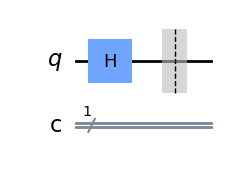

In [9]:
# Fourier transformer with a single qubit is just a hadamard gate. 

q1Class = FourierClass(1)
q1 = q1Class.build_manually()
q1.draw()

<h4><b>Demonstrating Unitarity</b></h4>

This Fourier Transform circuits show a unitarity property, which means a QFT circuit combined with inverse QFT circuit would results in an identity matrix. 

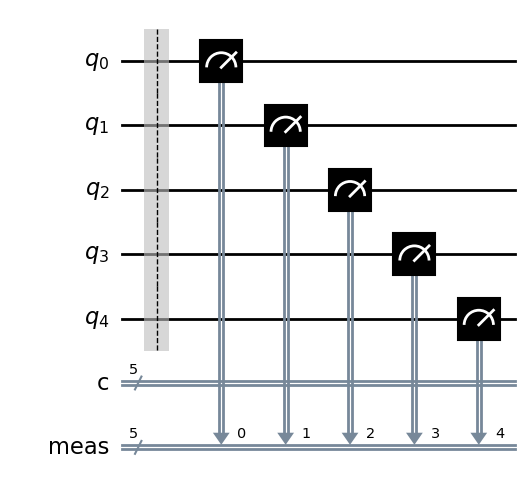

In [10]:
# this is a control "circuit" that does not do nothing. The circuit with 5 qubit is initialized, but nothing is added there before measurement. 
raw = FourierClass(5).get_circuit()
raw.measure_all()
raw.draw()

/tmp/ipykernel_81/2083201217.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
/tmp/ipykernel_81/2083201217.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


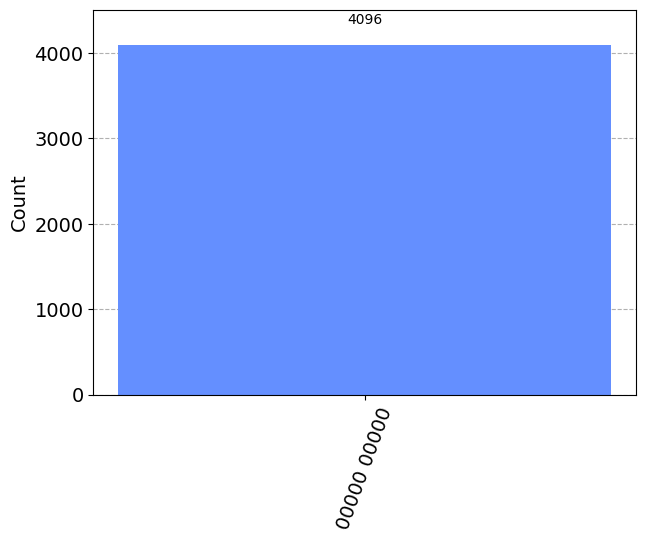

In [10]:
provider = IBMQ.load_account()
backend = Aer.get_backend('qasm_simulator')

# load raw empty circuit and run. The result is 0 as expected. 
raw_job = backend.run(transpile(raw, backend), shots=4096)
raw_result = raw_job.result()
raw_counts = raw_result.get_counts(raw)

plot_histogram(raw_counts)

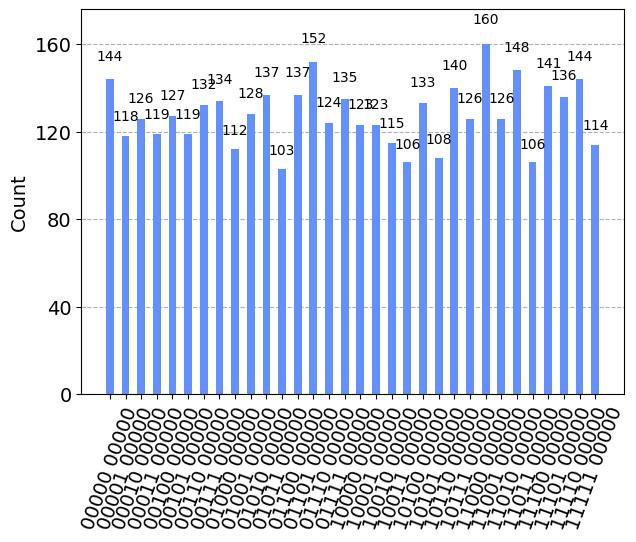

In [11]:
# now load with a 5 qubit fourier transformer. The result shows that there was a transformation
q5 = FourierClass(5).build_manually()

q5_job = backend.run(transpile(q5, backend), shots=4096)
q5_result = q5_job.result()
q5_counts = q5_result.get_counts(q5)

plot_histogram(q5_counts)

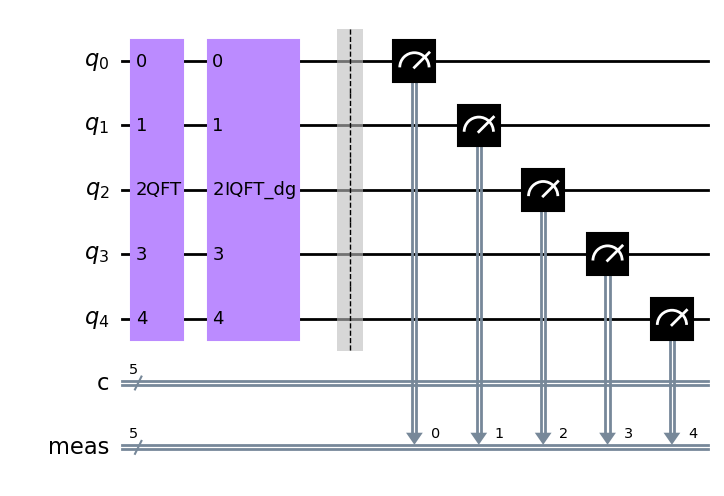

In [11]:
# this will create a Fourier transform, then inverse transform. 
# the result shows back to the raw zero state. 
q5class = FourierClass(5)

combined = q5class.build()
reverse = FourierClass(5, True)
qr5 = reverse.build()

combined &= qr5
combined.measure_all()
combined.draw()

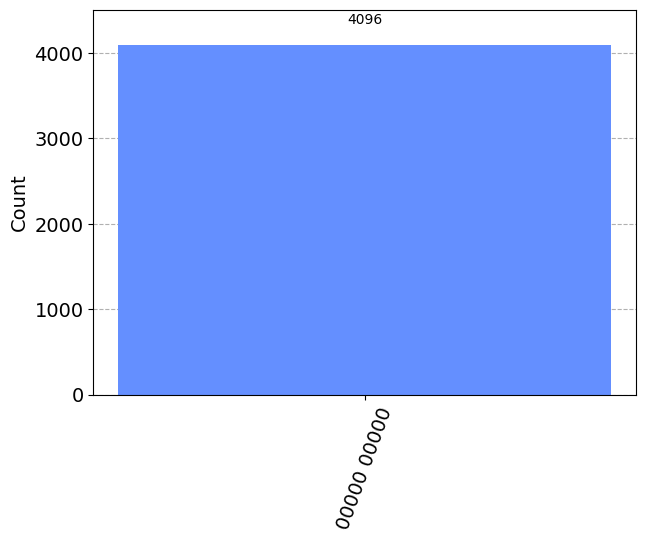

In [13]:
combined_job = backend.run(transpile(combined, backend), shots=4096)
combined_result = combined_job.result()
combined_counts = combined_result.get_counts(combined)

combined_counts
plot_histogram(combined_counts)

<h4><b>Shor Algorithm</b></h4>

Shor Algorithm consists of two parts: quantum phase estimation and then inverse fourier transformation. 

In [31]:
class ShorClass:
    def __init__(self, a, n, m):
        if a not in [2,4,7,8,11,13]:
            raise ValueError("'a' must be 2,4,7,8,11,13")
        
        # copy the params to properties
        self.a = a
        self.n = n
        self.m = m
        
        # initialize the circuit
        # for n = 4 and m = 4, it will have 8 qubits, and 4 classical registers. 
        circuit = QuantumCircuit(n + m, m)
        
        # for n = 4, hadamard gate on top 4
        circuit.h(range(n))
        
        # pauli x gate on the last one at the bottom
        circuit.x(n+m -1)
        
        # put this circuit as the property
        self.circuit = circuit
        
    # this is the gate function to be used for phase estimation    
    def u_gate(self, x):
        U = QuantumCircuit(4)        
        for iteration in range(x):
            if self.a in [2,13]:
                U.swap(0,1)
                U.swap(1,2)
                U.swap(2,3)
            if self.a in [7,8]:
                U.swap(2,3)
                U.swap(1,2)
                U.swap(0,1)
            if self.a == 11:
                U.swap(1,3)
                U.swap(0,2)
            if self.a in [7,11,13]:
                for q in range(4):
                    U.x(q)
        U = U.to_gate()
        U.name = "%i^%i mod 15" % (self.a, x)
        c_U = U.control()
        return c_U
    
    # phase estimator
    def phase_estimate(self):
        for x in range(self.n):
            exponent = 2**x
            self.circuit.append(self.u_gate(exponent), 
                     [x] + list(range(self.n, self.n+self.m)))
            
    # apply inverse Fourier transformation. It uses the FourierClass defined above        
    def apply_inverse_qft(self):
        qft = FourierClass(self.n, True).build()        
        final = self.circuit.compose(qft, range(self.n))
        self.circuit = final
        
    
    # measure only the top n 
    def measure_relevant(self):
        self.circuit.measure(range(self.n), range(self.n))
    
    # this will assemble all together and build a circuit. 
    def build(self):
        self.circuit.barrier()
        self.phase_estimate()
        self.circuit.barrier()        
        self.apply_inverse_qft()
        self.measure_relevant()
        return self.circuit
    
    def get_circuit(self):
        return self.circuit
    
    # convert the binary key to something easy to understand
    def convert(self, num):
       # convert the binary numbers to decimal
       dec = int(num, 2)   
    
       # discard 0's, such as 000, 0000
       if (dec == 0):
           return -1

       # odd numbers are useless, as we cannot do any further operation based on 2
       if (dec %2 == 1):
           return -1    
    
       # get the magic number
       x = int((self.a ** (dec/2)) % 15)    
    
       # if the lower pair (x -1) is 0 or 1, it is not usable
       if (x-1 <= 1):
           return -1    
               
       return x


    # convert and filter the keys from the result
    def filter(self, result):
        return {self.convert(k): v for k, v in result.items() if self.convert(k) > 0}
           
    # run the job on the backed
    def run(self, backend):
        job = backend.run(transpile(self.circuit, backend), shots=4096)
        result = job.result()
        return result.get_counts(self.circuit)
    
    # do the factor
    def factor(self, backend):
        # build the circuit
        self.build()
        
        # run the circuit with simulator
        measurement = self.run(backend) 
        
        # get the result filtered
        result = self.filter(measurement)        
        
        # get the key with the most values, as it is most likely to be the match
        x = max(result, key=result.get) 
        
        # return the factor, as well as the raw measurement and filtered result
        return {"factors": (gcd(x-1, 15), gcd(x+1, 15)), "measurement": measurement, "result": result}
        
        
            

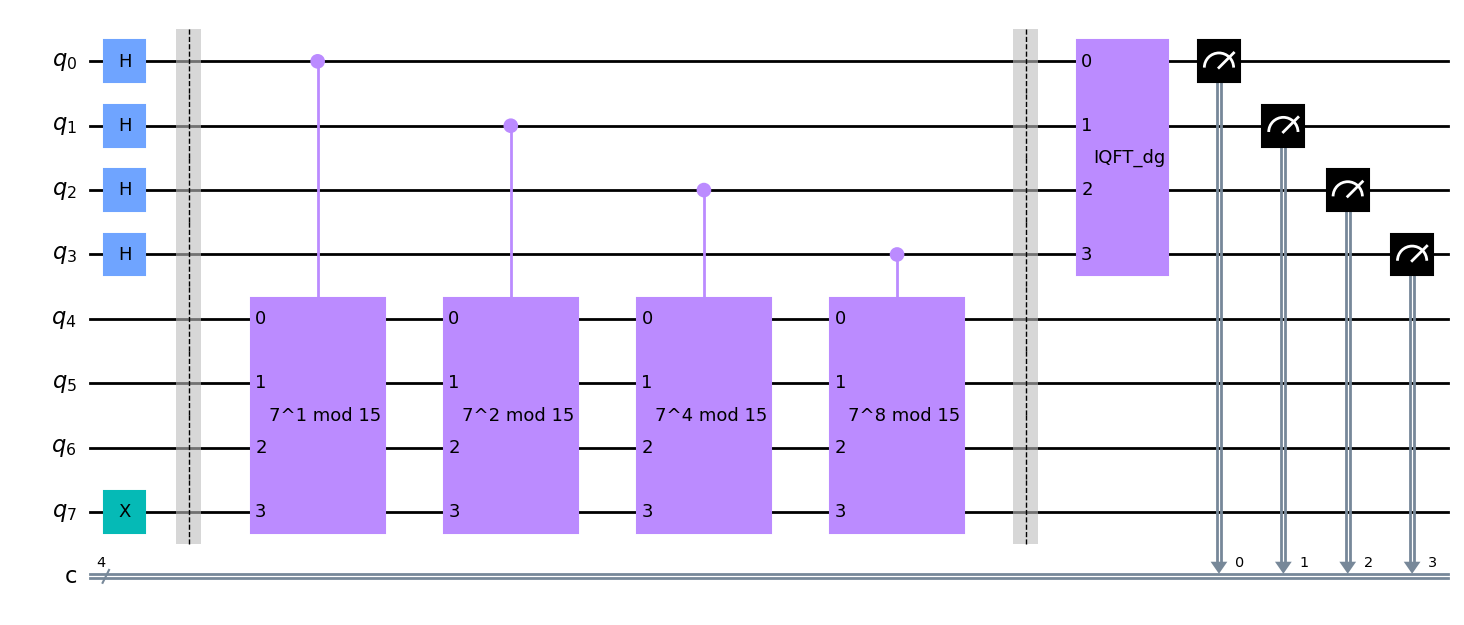

In [29]:
#diagram
shorClass = ShorClass(7, 4, 4)

shorClass.build()

shor15 = shorClass.get_circuit()
shor15.draw()


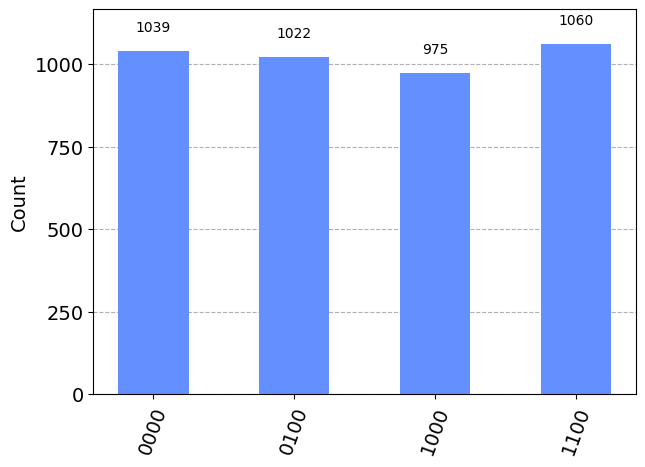

In [23]:
# run the algorithm with simulator and visualize the output. While this shows 4 results with similar frequencies, only 0100 is relevant 
job = backend.run(transpile(shor15, backend), shots=4096)
result = job.result()
counts = result.get_counts(shor15)

plot_histogram(counts)

In [32]:
# create a new Shor class, then run the factor. 
# it shows that 3 x 5 = 15
newClass = ShorClass(7, 4, 4)
newClass.factor(backend)

{'factors': (3, 5),
 'raw_result': {'1100': 952, '1000': 1055, '0000': 1039, '0100': 1050},
 'result': {4: 1050}}